# Tutorial IBS

In [1]:
import IBSLib as ibslib
import numpy as np
import pandas as pd

For getting help:
```python
help(ibslib.Nagaitsev)
```

Help on built-in function Nagaitsev in module IBSLib:

Nagaitsev(...) method of builtins.PyCapsule instance
    Nagaitsev(pnumber: float, emitx: float, emity: float, bunchLength: float, dpop: float, twissHeaderMap: Dict[str, float], twissTableMap: Dict[str, List[float]], classicalRadius: float, outputArray: numpy.ndarray[numpy.float64]) -> None
    
    Nagaitsev

## Physical Constants


In [2]:
print("{:35} : {:12.8e}".format("Speed of light in m/s", ibslib.clight))
print("{:35} : {:12.8e}".format("Reduced Planck constant in GeV ", ibslib.hbarGeV))
print("{:35} : {:12.8e}".format("Electron Mass in GeV", ibslib.electron_mass))
print("{:35} : {:12.8e}".format("Proton Mass in GeV", ibslib.proton_mass))
print("{:35} : {:12.8e}".format("Neutron Mass in GeV", ibslib.neutron_mass))
print("{:35} : {:12.8e}".format("Muon Mass in GeV", ibslib.mu_mass))
print("{:35} : {:12.8e}".format("Atomic Mass Unit in GeV", ibslib.atomic_mass_unit))
print("{:35} : {:12.8e}".format("Pi", ibslib.pi))
print("{:35} : {:12.8e}".format("Electric Charge in Coulomb", ibslib.electric_charge))
print("{:35} : {:12.8e}".format("Euler Constant", ibslib.euler))
print("{:35} : {:12.8e}".format("Classical Electron Radius in m", ibslib.electron_radius))
print("{:35} : {:12.8e}".format("Classical Proton Radius in m ", ibslib.proton_radius))


Speed of light in m/s               : 2.99792458e+08
Reduced Planck constant in GeV      : 6.58211957e-25
Electron Mass in GeV                : 5.10998950e-04
Proton Mass in GeV                  : 9.38272088e-01
Neutron Mass in GeV                 : 9.39565421e-01
Muon Mass in GeV                    : 1.05658375e-01
Atomic Mass Unit in GeV             : 9.31494102e-01
Pi                                  : 3.14159265e+00
Electric Charge in Coulomb          : 1.60217663e-19
Euler Constant                      : 5.77215665e-01
Classical Electron Radius in m      : 2.81794033e-15
Classical Proton Radius in m        : 1.53469827e-18


## Twiss

- Cpymad
- from file
    * read header
    * read table
    * update -> adds radiation integrals per element (I1,I2,I3,I4x,I4y,I5x,I5y)

### Cpymad

In [3]:
from pprint import pprint
from cpymad.madx import Madx

lattice = "BII_1996-01-01_design_v_1.seq"
tfsfile = "b2_design.twiss"

mad = Madx()
mad.option.echo = False
mad.option.warn = False
mad.command.beam(energy=1.7, particle='electron')
mad.call(file=lattice)
mad.use(sequence='ring')
twiss = mad.twiss(file=tfsfile, chrom=True)
pprint(dict(twiss.summary))

{'alfa': 0.0007316942746,
 'bcurrent': 2.001335116e-13,
 'betxmax': 17.43722837,
 'betymax': 21.09492526,
 'bv_flag': 1.0,
 'charge': -1.0,
 'deltap': 0.0,
 'dq1': 1.077745266,
 'dq2': 1.371772348,
 'dxmax': 0.4496533372,
 'dxrms': 0.2272073799,
 'dymax': 0.0,
 'dyrms': 0.0,
 'energy': 1.7,
 'et': 0.001,
 'ex': 1.0,
 'ey': 1.0,
 'gamma': 3326.817012,
 'gammatr': 36.9687845,
 'kbunch': 1.0,
 'length': 240.0,
 'mass': 0.00051099895,
 'npart': 1.0,
 'orbit5': -0.0,
 'particle': 'ELECTRON',
 'pc': 1.699999923,
 'q1': 17.84996563,
 'q2': 6.743031469,
 'sequence': 'RING',
 'sige': 0.001,
 'sigt': 1.0,
 'synch_1': 0.1756066259,
 'synch_2': 1.442924619,
 'synch_3': 0.3313655981,
 'synch_4': -0.004653715528,
 'synch_5': 0.001749753833,
 'xcomax': 0.0,
 'xcorms': 0.0,
 'ycomax': 0.0,
 'ycorms': 0.0}


###  From File

In [4]:
# read twiss summary / header as dictionary
twissHeader = ibslib.GetTwissHeader(tfsfile)

In [5]:
# read twiss table as dictionary - only reads IBS relevant columns from Twiss (data reduction)
twissTable = ibslib.GetTwissTable(tfsfile)
print(list(twissTable.keys()))

['ALFX', 'ALFY', 'ANGLE', 'BETX', 'BETY', 'DPX', 'DPY', 'DX', 'DY', 'K1L', 'K1SL', 'L']


In [6]:
# update Twiss with radiation integrals and related quantities needed later on (come back to this later)
twissTable = ibslib.updateTwiss(twissTable)
print(list(twissTable.keys()))

['ALFX', 'ALFY', 'ANGLE', 'BETX', 'BETY', 'DPX', 'DPY', 'DX', 'DY', 'I1', 'I2', 'I3', 'I4x', 'I4y', 'I5x', 'I5y', 'K1L', 'K1SL', 'L', 'gammax', 'gammay', 'hx', 'hy', 'k', 'rho']


print values of twiss column

```python
ibslib.printTwissColumn("BETX",twissTable)
```

## Radiation Damping
- RadiationDampingApprox
- RadiationDampingLattice
- RadiationDampingEquilibria

###  Radiation Damping Approx

Uses ring averages (Tunes -> beta average, average bending radius, etc...)

In [7]:
df     = pd.DataFrame.from_dict(twissTable,orient='columns')
rhoAvg = df.loc[df.rho != 0.0,'rho'].mean()

gamma    = twissHeader['GAMMA']
gamma_tr = twissHeader['GAMMATR']
circ     = twissHeader['LENGTH']

bxAvg = circ / (2.0 * ibslib.pi * twissHeader["Q1"]); 
byAvg = circ / (2.0 * ibslib.pi * twissHeader["Q2"]);

radint = np.zeros(7)
ibslib.RadiationDampingApprox(circ, gamma, gamma_tr, rhoAvg, bxAvg, byAvg, radint);
radint

array([1.540409  , 1.44292462, 0.3313656 , 0.        , 0.        ,
       0.07523688, 0.        ])

### Radiation Damping Lattice

Uses Twiss Table

In [8]:
ibslib.RadiationDampingLattice(twissTable, radint)
radint

array([ 0.26299979,  1.44292462,  0.3313656 , -0.00465372,  0.        ,
        0.00201665,  0.        ])

### Radiation damping Equilibria

Values are used in the ODE simulations!!

In [9]:
gamma   = twissHeader.get('GAMMA')
pc      = twissHeader.get('PC')
gammatr = twissHeader.get('GAMMATR')
mass    = twissHeader.get('MASS')
charge  = twissHeader.get('CHARGE')
q1      = twissHeader.get('Q1')
l       = twissHeader.get('LENGTH')

aatom   = ibslib.electron_mass / ibslib.proton_mass
betar   = ibslib.beta_relativistic_from_gamma(gamma) # see numeric functions
r0      = ibslib.particle_radius(1, aatom) # see numeric functions
trev    = l / (betar * ibslib.clight)
frev    = 1.0 / trev
omega   = 2.0 * ibslib.pi * frev
eta     = ibslib.eta(gamma, gammatr)
epsilon = 1.0e-6 # accuracy for synchronuous phase search

radint = np.zeros(7)
ibslib.RadiationDampingLattice(twissTable, radint)

target_energy_gain_ev    = 0.0
intial_phis_search_value = 173
harmon                   = [400.0]
voltages                 = [-4. * 375000.]

# methods below are described/ demonstrated in the numeric functions part
U0     = ibslib.get_energy_loss_per_turn(twissHeader, radint[1], aatom) 
phis   = ibslib.get_synchronuous_phase(target_energy_gain_ev, intial_phis_search_value, U0, charge, harmon,voltages,epsilon)
qs     = ibslib.get_synchrotron_tune(omega, U0, charge, harmon, voltages, phis, eta, pc)
omegas = qs * omega

equi = np.zeros(9)
ibslib.RadiationDampingEquilibria(twissHeader, radint, aatom, qs, equi)
print("{:10} : {:10.6e} ({})\n".format("Energy Loss per Turn", U0, "eV"));
print("{:10} : {:10.6e} ({})".format("Taux", equi[0], "s"));
print("{:10} : {:10.6e} ({})".format("Tauy", equi[1], "s"));
print("{:10} : {:10.6e} ({})".format("Taus", equi[2], "s"));
print("{:10} : {:10.6e} ({})".format("exinf", equi[3], ""));
print("{:10} : {:10.6e} ({})".format("eyinf", equi[4], ""));
print("{:10} : {:10.6e} ({})".format("sigeoe2", equi[5], ""));
print("{:10} : {:10.6e} ({})".format("sigsinf", equi[6], ""));
print("{:10} : {:10.6e} ({})".format("jx", equi[7], ""));
print("{:10} : {:10.6e} ({})".format("jy", equi[8], ""))

Energy Loss per Turn : 1.702619e+05 (eV)

Taux       : 7.967527e-03 (s)
Tauy       : 7.993224e-03 (s)
Taus       : 3.990177e-03 (s)
exinf      : 5.908327e-09 ()
eyinf      : 9.415563e-14 ()
sigeoe2    : 4.877655e-07 ()
sigsinf    : 3.054559e-03 ()
jx         : 1.003225e+00 ()
jy         : 1.000000e+00 ()


## Numeric Functions

- Standard util functions
- Longitudinal / RF
- IBS specific numeric functions

### Standard functions

In [10]:
betar   = ibslib.beta_relativistic_from_gamma(gamma)
eta     = ibslib.eta(gamma, gammatr)
r0      = ibslib.particle_radius(1, aatom)

sige    = np.sqrt(equi[5])
dpop    = ibslib.dee_to_dpp(sige, betar)
deoe    = ibslib.dpp_to_dee(dpop, betar)
betar, eta, r0, sige, dpop, deoe

(0.999999954823541,
 0.0007316942747206528,
 2.8179403262e-15,
 0.0006984020902062896,
 0.0006984021532869811,
 0.0006984020902063293)

### Longitudinal / RF
- sigs_from_sige
- sige_from_sigs
- rf_voltage_in_eV - energy gain in eV -> to be able to find $\phi_s$
- rf_voltage_in_ev_prime - derivative of rf_voltage_in_eV 
- rf_voltage_in_ev_with_rad_losses
- get_synchronuous_phase
- rf_voltage_with_potential_well_distortion
- rf_voltage_with_potential_well_distortion_prime
- get_synchronuous_phase_with_potential_well_distortion
- get_synchrotron_tune
- get_synchrotron_tune_with_potential_well
- sige_form_sigs_using_rf

In [11]:
# sigma_s from sigma_e
sigs = ibslib.sigs_from_sige(sige, gamma, gammatr, omegas)
sigs, sige

(0.003054558934794126, 0.0006984020902062896)

In [12]:
# sigma_e from sigma_s
sigen = ibslib.sige_from_sigs(omega, sigs, qs, gamma, gammatr)
sigs,sigen

(0.003054558934794126, 0.0006984020902062895)

In [13]:
phi = 173
ibslib.rf_voltage_in_ev(phi, charge, harmon,voltages), ibslib.rf_voltage_in_ev_prime(phi, charge, harmon,voltages)

(182804.01510772132, -1488819.227461983)

In [14]:
# offset to be on synchronuous phase
ibslib.rf_voltage_in_ev_with_rad_losses(phi, charge, U0, harmon, voltages)

12542.106380552286

In [15]:
# synchronuous phase
phis   = ibslib.get_synchronuous_phase(target_energy_gain_ev, intial_phis_search_value, U0, charge, harmon,voltages,epsilon)
intial_phis_search_value, phis, ibslib.rf_voltage_in_ev_with_rad_losses(phis, charge, U0, harmon, voltages)

(173, 173.48242725610714, 9.92469722405076e-07)

In [16]:
# synchrotron tune 
ibslib.get_synchrotron_tune(omega, U0, charge, harmon, voltages, phis, eta, pc)

0.006390253850181927

In [17]:
ibslib.sige_form_sigs_using_rf(sigs, U0, charge, harmon, voltages, gamma,gammatr, pc, circ, phis, True), sige

(0.0006984021533089606, 0.0006984020902062896)

### IBS specific

In [18]:
# numeric functions used in IBS growth rate calculations
ibslib.fmohl(1.,2.,3.,1000), ibslib.rds(1.0,2.0,3.0)

(-5.404172967883225, 0.29046028102188937)

## Coulomb Log
- twclog
- twclogtail
- coulomblog
- coulomblogtail

The first two methods are used in the simulation and are designed to be applied on an element by element basis. 
The second two use ring averages and can be used to get an idea of the values.

In [19]:
pnumber = 1.0e10
restE   = twissHeader['ENERGY']
clog    = np.zeros(2)
clogt   = np.zeros(2)

# using ring averages
ibslib.coulomblog(pnumber, equi[3], equi[4], twissHeader, sige, sigs, r0, True, clog)
ibslib.coulomblogtail(pnumber, equi[3], equi[4], twissHeader, sige, sigs, equi[0], equi[1], equi[2], r0, True, clogt)

print("{:30} : {:12.6e}".format("Coulomb Log", clog[0]))
print("{:30} : {:12.6e}".format("Coulomb IBS pre-factor", clog[1]))
print()
print("{:30} : {:12.6e}".format("Coulomb Log Tailcut", clogt[0]))
print("{:30} : {:12.6e}".format("Coulomb IBS pre-factor Tailcut", clogt[1]))
print()


print("Element weighted")
print("================")
# element by element weighted
avgclog  = 0.0;
avgclogc = 0.0;

# without tailcut
for i in range(len(twissTable["L"])):
    ibslib.twclog(pnumber, twissTable["BETX"][i], twissTable["BETY"][i],
           twissTable["DX"][i], twissTable["DY"][i], equi[3], equi[4], r0,
           gamma, charge, restE, mass, sige, sigs, clog);
    avgclog  += twissTable["L"][i] * clog[0];
    avgclogc += twissTable["L"][i] * clog[1];
    
avgclog  /= twissHeader["LENGTH"];
avgclogc /= twissHeader["LENGTH"];

print("{:30} : {:12.6e}".format("Coulomb Log", avgclog))
print("{:30} : {:12.6e}".format("Coulomb IBS pre-factor", avgclogc))
print()

# with tailcut
for i in range(len(twissTable["L"])):
    ibslib.twclogtail(pnumber, twissTable["L"][i], twissTable["BETX"][i],
               twissTable["BETY"][i], twissTable["DX"][i],
               twissTable["DPX"][i], twissTable["DY"][i],
               twissTable["DPY"][i], twissTable["ALFX"][i],
               twissTable["ALFY"][i], twissTable["ANGLE"][i],
               twissTable["K1L"][i], twissTable["K1SL"][i], equi[3],
               equi[4], r0, aatom, gamma, restE, circ, mass, charge, sige, sigs,
               clogt);
    avgclog  += twissTable["L"][i] * clogt[0];
    avgclogc += twissTable["L"][i] * clogt[1];
    
avgclog  /= twissHeader["LENGTH"];
avgclogc /= twissHeader["LENGTH"];

print("{:30} : {:12.6e}".format("Coulomb Log Tailcut", avgclog))
print("{:30} : {:12.6e}".format("Coulomb IBS pre-factor Tailcut", avgclogc))

Coulomb Log                    : 1.742574e+01
Coulomb IBS pre-factor         : 1.135416e+02

Coulomb Log Tailcut            : 9.002388e+00
Coulomb IBS pre-factor Tailcut : 5.865725e+01

Element weighted
Coulomb Log                    : 1.654592e+01
Coulomb IBS pre-factor         : 1.078089e+02

Coulomb Log Tailcut            : 1.582737e+01
Coulomb IBS pre-factor Tailcut : 1.031271e+02


## Integrands and integrals
- Simpson
- Simpson Decade
- Simpson Decade with scaling for Zimmerman Models as implemented in MADX
- Integrand Function that can be passed to the integrators (Bjorken-Mtingwa, Conte-Martini, Zimmerman)
- Demo with IBS models as individually hard to compare due to different integrands. (test_cpp_integrators.py in unit tests for some examples)

## IBS models
- Numeric approximation function (fast)
    - Piwinski smooth
    - Piwinski lattice
    - Piwinski Modified
    - Nagaitsev without and with tailcut
- Using integration
    - Zimmerman model - madx with and without tailcut using scaled Simpson Decade
    - Bjorken-Mtingwa Simpson (least accurate)
    - Bjorken-Mtingwa Simpson Decade with and without tailcut
    - Conte-Martini Simpson Decade with and without tailcut
    - Zimmerman model with Simpson Decade

**Note: all use coulomb constants element weighted - different from previous implementations.**

In [20]:
print("IBS Models");
print("==========");
printf = lambda model, te, tx, ty: "{:40}\t{:<12.6f}\t{:<12.6f}\t{:<12.6f}".format(model, te, tx, ty)
print("{:40}\t{:12}\t{:12}\t{:12}".format('Model', "te2", "tex", "tey"))
res = np.zeros(3)
sige0 = 1e-4;

ibslib.PiwinskiSmooth(pnumber, equi[3], equi[4], sigs, ibslib.dee_to_dpp(sige0, betar), twissHeader, r0, res);
print(printf("Piwinski Smooth", *(0.5/res)));

ibslib.PiwinskiLattice(pnumber, equi[3], equi[4], sigs, ibslib.dee_to_dpp(sige0, betar), twissHeader, twissTable, r0, res);
print(printf("Piwinski Lattice", *(0.5/res)));

ibslib.PiwinskiLatticeModified(pnumber, equi[3], equi[4], sigs, ibslib.dee_to_dpp(sige0, betar), twissHeader, twissTable, r0, res);
print(printf("Piwinski Lattice Modified", *(0.5/res)));

ibslib.Nagaitsev(pnumber, equi[3], equi[4], sigs, ibslib.dee_to_dpp(sige0, betar), twissHeader, twissTable, r0, res);
print(printf("Nagaitsev", *(0.5/res)));

ibslib.NagaitsevTailcut(pnumber, equi[3], equi[4], sigs, ibslib.dee_to_dpp(sige0, betar), twissHeader, twissTable, r0, aatom, res);
print(printf("Nagaitsev Tailcut", *(0.5/res)));

# IBS METHODS WITH DEDICATED INTEGRATORS
# ================================================================================

ibslib.Zimmerman(pnumber, equi[3], equi[4], sigs, sige0, twissHeader, twissTable, r0, True, res);
print(printf("Zimmerman scaled Simpson Decade", *(0.5/res)));

ibslib.ZimmermanTailcut(pnumber, equi[3], equi[4], sigs, sige0, twissHeader, twissTable, r0, aatom, res);
print(printf("Zimmerman scaled Simpson Decade Tailcut", *(0.5/res)));

ibslib.BjorkenMtingwaSimpson(pnumber, equi[3], equi[4], sigs, ibslib.dee_to_dpp(sige0, betar), twissHeader, twissTable, r0, res);
print(printf("Bjorken Mtingwa Simpson", *(0.5/res)));

ibslib.BjorkenMtingwaSimpsonDecade(pnumber, equi[3], equi[4], sigs, ibslib.dee_to_dpp(sige0, betar), twissHeader, twissTable, r0, res);
print(printf("Bjorken Mtingwa Simpson Decade", *(0.5/res)));

ibslib.BjorkenMtingwaTailcutSimpsonDecade(pnumber, equi[3], equi[4], sigs, ibslib.dee_to_dpp(sige0, betar), twissHeader, twissTable, r0, aatom, res);
print(printf("Bjorken Mtingwa Simpson Decade Tailcut", *(0.5/res)));

ibslib.ConteMartiniSimpsonDecade(pnumber, equi[3], equi[4], sigs, ibslib.dee_to_dpp(sige0, betar), twissHeader, twissTable, r0, res);
print(printf("Conte Martini Simpson Decade", *(0.5/res)));

ibslib.ConteMartiniTailcutSimpsonDecade(pnumber, equi[3], equi[4], sigs, ibslib.dee_to_dpp(sige0, betar), twissHeader, twissTable, r0, aatom, res);
print(printf("Conte Martini Simpson Decade Tailcut", *(0.5/res)));

ibslib.ZimmermanSimpsonDecade(pnumber, equi[3], equi[4], sigs, ibslib.dee_to_dpp(sige0, betar), twissHeader, twissTable, r0, res);
print(printf("Zimmerman Simpson Decade", *(0.5/res)));

IBS Models
Model                                   	te2         	tex         	tey         
Piwinski Smooth                         	0.000041    	0.072543    	0.000866    
Piwinski Lattice                        	0.000060    	0.011744    	0.000650    
Piwinski Lattice Modified               	0.000060    	0.011751    	0.000651    
Nagaitsev                               	0.000033    	0.006027    	0.000422    
Nagaitsev Tailcut                       	0.000035    	0.006492    	0.000459    
Zimmerman scaled Simpson Decade         	0.000032    	0.005843    	0.000402    
Zimmerman scaled Simpson Decade Tailcut 	0.000033    	0.006147    	0.000440    
Bjorken Mtingwa Simpson                 	0.000031    	0.005637    	0.000411    
Bjorken Mtingwa Simpson Decade          	0.000031    	0.005572    	0.000413    
Bjorken Mtingwa Simpson Decade Tailcut  	0.000032    	0.006003    	0.000450    
Conte Martini Simpson Decade            	0.000032    	0.005757    	0.000403    
Conte Martini Simpson Decade 

Keep in mind that the Piwinski models do not use an elment weighted Coulomb Log calculation, but it is embedded in the analytical function used.

## ODE simulations

In [21]:
from ibs import print_model_map
print_model_map()

{0: 'All', 1: 'Piwinski Smooth', 2: 'Piwinski Lattice', 3: 'Piwinski Lattice Modified', 4: 'Nagaitsev', 5: 'Nagaitsev Tailcut', 6: 'Zimmerman Simpson Decade Scaling', 7: 'Zimmerman Simpson Decade Scaling with Tailcut', 8: 'Bjorken-Mtingwa Standard Simpson', 9: 'Bjorken-Mtingwa Simpson Decade', 10: 'Bjorken-Mtingwa Simpson Decade Tailcut', 11: 'Conte-Martini Simpson Decade', 12: 'Conte-Martini Simpson Decade Tailcut', 13: 'Zimmerman Simpson Decade'}


In [22]:
# for the CLI command this is read from a json file
sim_input= {
    "twissfile": "b2_design.twiss",
    "harmon": [
        400.0
    ],
    "voltages": [
        -1.5e6
    ],
    "ex": 7.5e-9,
    "ey": 1e-10,
    "sigs": 0.005,
    "model": 1,
    "pnumber": 1e10,
    "coupling": 0,
    "threshold": 1e-3,
    "outfile": "sim_test.csv",
    "plotfile": "sim_test.png"
}

In [23]:
twissheader = ibslib.GetTwissHeader(sim_input["twissfile"])
twisstable = ibslib.GetTwissTable(sim_input["twissfile"])
twisstable = ibslib.updateTwiss(twisstable)

pnumber = 1e10
ex = 5e-9
ey = 1e-10
sigs = 0.005

t = [0.0]
exa = [sim_input['ex']]
eya = [sim_input['ey']]
sigsa = [sim_input['sigs']]
sigea = []
harmon = [400.0]
voltages = [-4.0 * 375e3]
coupling = 0
threshold = 1e-3

res = ibslib.runODE(
    twissheader,
    twisstable,
     sim_input["harmon"],
    sim_input["voltages"],
    t,
    exa,
    eya,
    sigsa,
    sigea,
    sim_input["model"],
    sim_input["pnumber"],
    sim_input["coupling"],
    sim_input["threshold"],
    "der"
)

df = pd.DataFrame.from_dict(res, orient='columns')


Synchrotron Tune : 6.390254e-03
 Synchrotron freq : 5.015421e+04
 Sige             : 6.984022e-04
 Radius max          : 4.08388714e-03
Density             : 1.24561741e-05
CONST               ; 1.13541624e+02
ENERGY              ; 1.70000000e+00 GeV
BETA                ; 9.99999955e-01
GAMMA               ; 3.32681701e+03
COULOMB LOG         ; 1.74257370e+01
X-emittance         ; 5.90832712e-09 m*rad
Y-emittance         ; 9.41556346e-14 m*rad
Momentum spread     ; 6.98402090e-04
Bunch length        ; 3.05455893e-03 m 
Particles per bunch ; 1.00000000e+10
Bunch current       ; 2.00133521e-03 A
Radius max          : 4.08388714e-03
Density             : 1.24561699e-05
CONST               ; 5.86572496e+01
ENERGY              ; 1.70000000e+00 GeV
BETA                ; 9.99999955e-01
GAMMA               ; 3.32681701e+03
COULOMB LOG         ; 9.00238847e+00
X-emittance         ; 5.90832712e-09 m*rad
Y-emittance         ; 9.41556346e-14 m*rad
Momentum spread     ; 6.98402090e-04
Bunch length 

**Note**:

The SigE0 in the above output are calculated using different methods (sigs_to_sige and using RF settings). Both results are included as a double check.

plotting


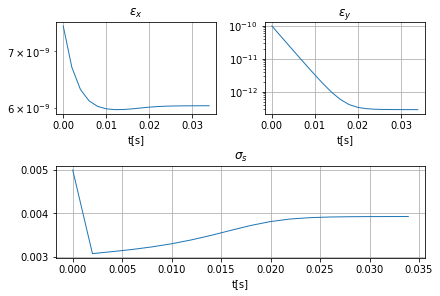

In [24]:
from ibs import plot
plot(df,sim_input, save=False)